# Importing Necessary Libraries

In [2]:
import os
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from scipy import signal
from PIL import Image  

# EDA- Exploratory Data Analysis

## 1.Load and display sample spectrograms

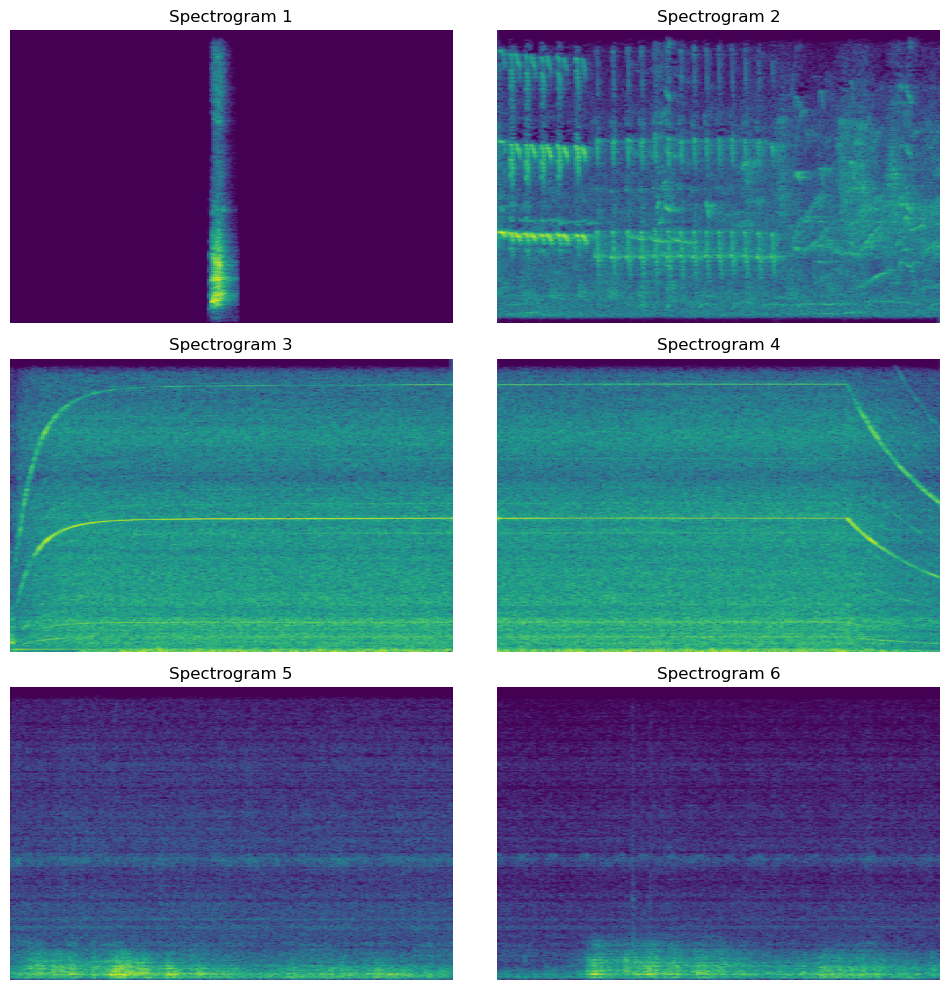

In [2]:
# Path to the folder containing spectrogram images
folder_path = "C:/College/DPL+EDA+PDS/Spectograms"

# Get a list of spectrogram image files in the folder
spectrogram_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]

# Create a 3x2 subplot for spectrograms
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# Loop through the spectrogram files and display them in subplots
for i in range(min(3 * 2, len(spectrogram_files))):
    img_path = os.path.join(folder_path, spectrogram_files[i])
    img = mpimg.imread(img_path)
    
    row = i // 2
    col = i % 2
    
    axs[row, col].imshow(img, cmap='viridis')  # You can choose a different colormap if needed
    axs[row, col].axis('off')  # Turn off axis labels

    axs[row, col].set_title(f'Spectrogram {i+1}')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## 2. Display the Spectograms by Class

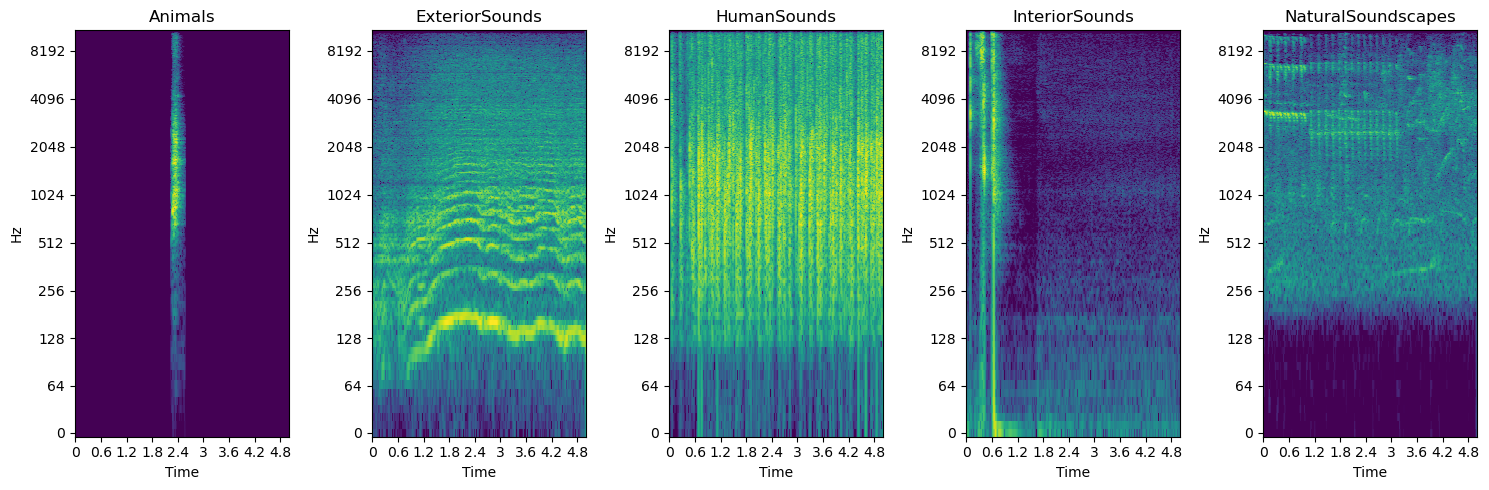

In [17]:

# Path to the folder containing audio files
dataset_folder = "C:/College/DPL+EDA+PDS/Audio1"

# Get the list of classes
classes = [class_name for class_name in os.listdir(dataset_folder) if os.path.isdir(os.path.join(dataset_folder, class_name))]

# Check if there are classes to display
if len(classes) > 0:
    # Create a 1xN subplot for each class
    fig, axs = plt.subplots(1, len(classes), figsize=(15, 5))

    for i, class_name in enumerate(classes):
        # Get the list of audio files for the current class
        audio_folder = os.path.join(dataset_folder, class_name)
        audio_files = [os.path.join(audio_folder, file) for file in os.listdir(audio_folder) if file.endswith('.wav')]

        # Take the first audio file from each class
        audio_file = audio_files[0]

        # Load the audio file
        y, sr = librosa.load(audio_file)

        # Generate the spectrogram
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

        # Display the spectrogram directly
        plt.sca(axs[i])
        librosa.display.specshow(D, sr=sr, cmap='viridis', x_axis='time', y_axis='log')
        plt.title(class_name)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()
else:
    print("No classes found in the dataset.")


## 3. Distribution of the Peaks of Spectograms

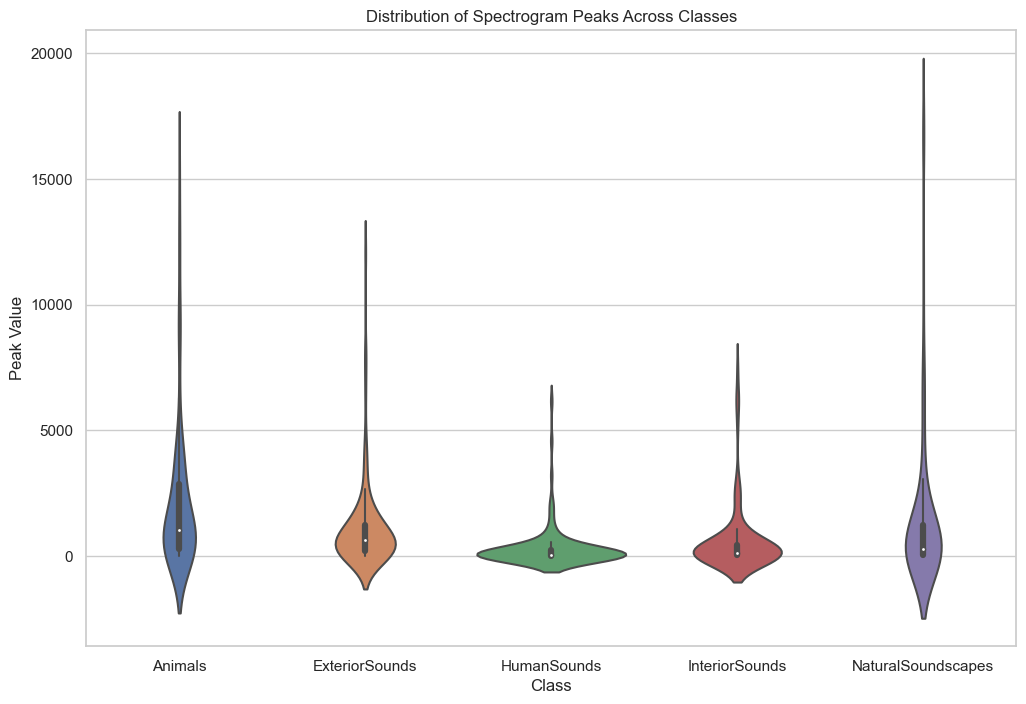

In [5]:

# Path to the folder containing audio files
folder_path = "C:/College/DPL+EDA+PDS/Audio1"

# List to store spectrogram peaks
peak_values = []

# Function to extract features from audio file
def extract_features(audio_file):
    y, sr = librosa.load(audio_file)
    spect = librosa.feature.melspectrogram(y=y, sr=sr)
    return spect.max()

# Loop through each class folder
for class_folder in os.listdir(folder_path):
    class_path = os.path.join(folder_path, class_folder)

    # Loop through each audio file in the class folder
    for audio_file in os.listdir(class_path):
        audio_path = os.path.join(class_path, audio_file)

        # Extract feature (max value in spectrogram) and append to the list
        peak_value = extract_features(audio_path)
        peak_values.append({"Class": class_folder, "Peak Value": peak_value})

# Convert the list to a Pandas DataFrame
import pandas as pd
df = pd.DataFrame(peak_values)

# Set Seaborn style
sns.set(style="whitegrid")

# Create a grid of violin plots
plt.figure(figsize=(12, 8))
sns.violinplot(x="Class", y="Peak Value", data=df)
plt.title("Distribution of Spectrogram Peaks Across Classes")
plt.show()


## 4. The local maximas plotted in the spectogram

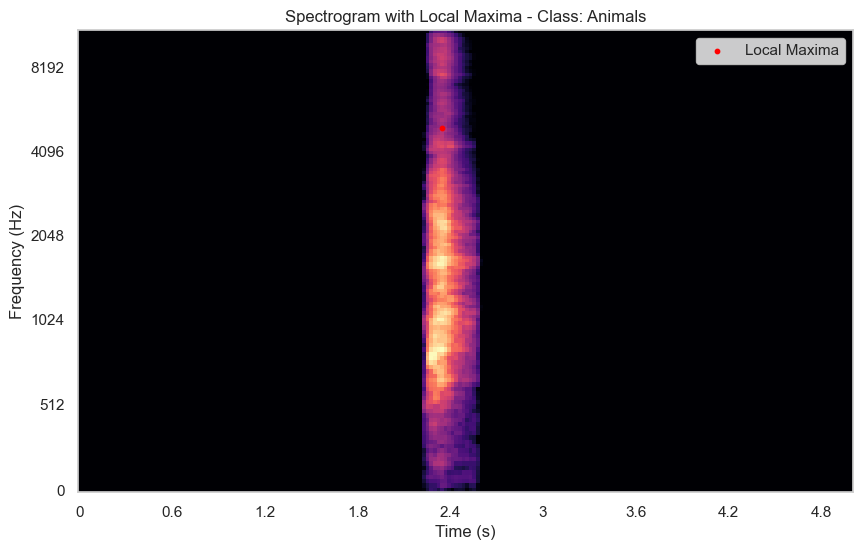

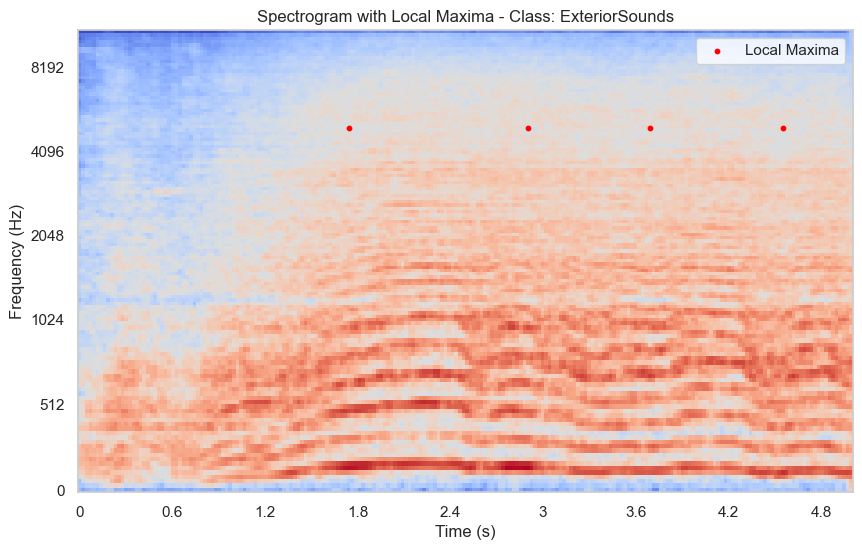

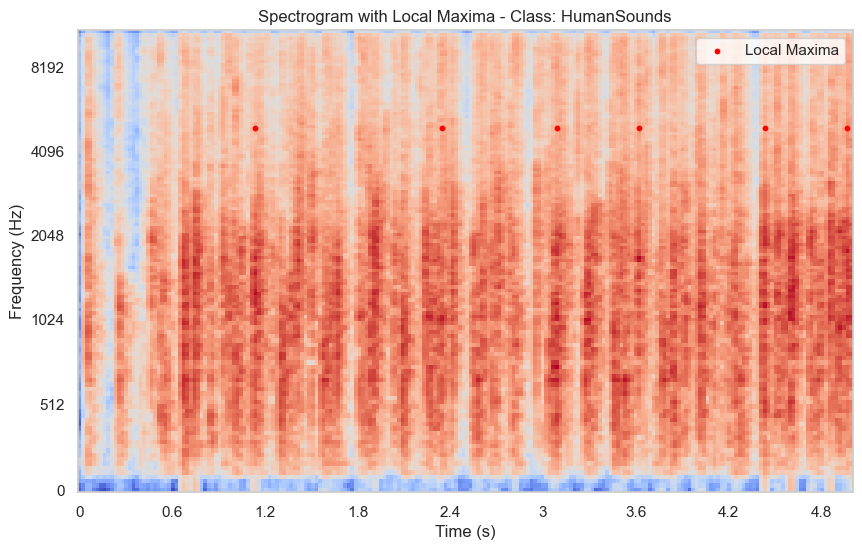

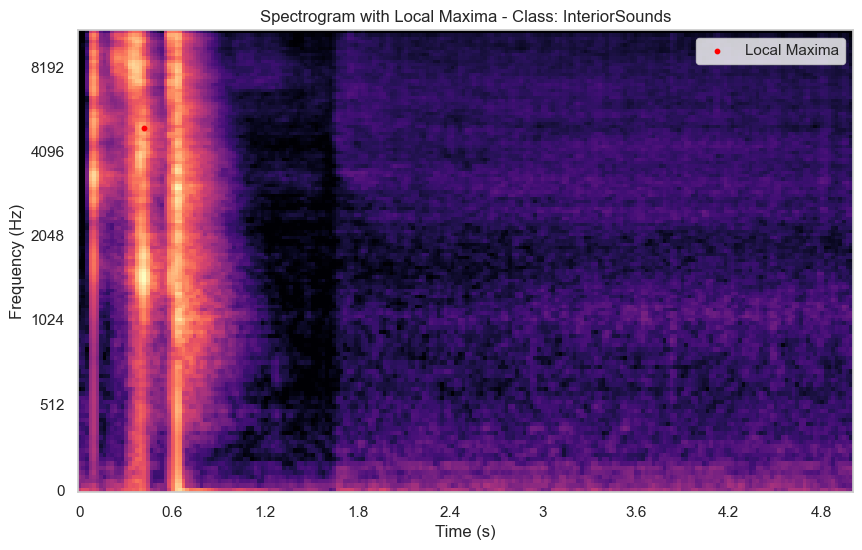

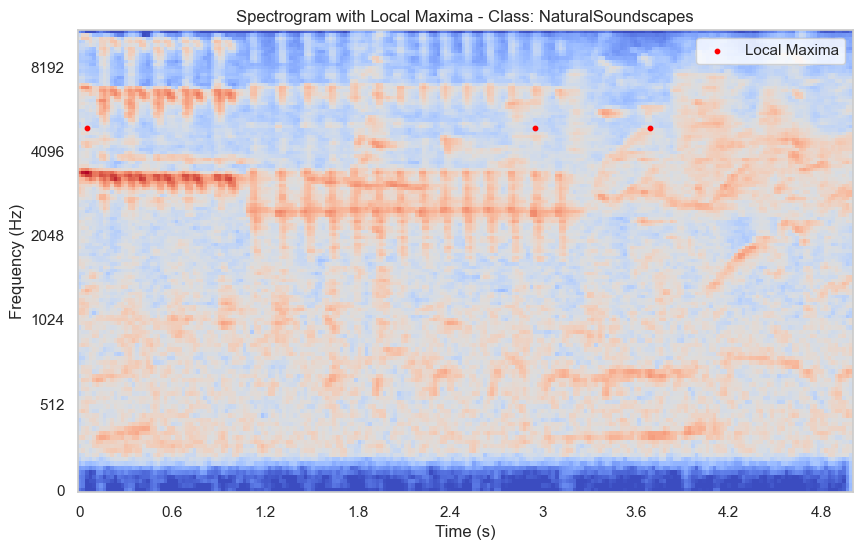

In [9]:


# Path to the folder containing audio files
folder_path = "C:/College/DPL+EDA+PDS/Audio1"

# Function to extract features from audio file
def extract_features(audio_file):
    y, sr = librosa.load(audio_file)
    spect = librosa.feature.melspectrogram(y=y, sr=sr)

    # Find local maxima in the spectrogram
    local_maxima = librosa.util.peak_pick(spect.max(axis=0), pre_max=20, post_max=20, pre_avg=50, post_avg=50, delta=0.5, wait=0)

    # Get times corresponding to the local maxima
    times = librosa.times_like(spect)

    # Convert the indices of local maxima to corresponding times
    times_maxima = times[local_maxima]

    return times_maxima

# Loop through each class folder
for class_folder in os.listdir(folder_path):
    class_path = os.path.join(folder_path, class_folder)

    # Choose only one audio file per class
    audio_file = os.listdir(class_path)[0]
    audio_path = os.path.join(class_path, audio_file)

    # Extract local maxima times
    times_maxima = extract_features(audio_path)

    # Plot local maxima on the spectrogram
    y, sr = librosa.load(audio_path)
    spect, ax = plt.subplots(figsize=(10, 6))
    librosa.display.specshow(librosa.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr)), y_axis='mel', x_axis='time', ax=ax)
    ax.scatter(times_maxima, np.ones_like(times_maxima) * 5000, color='red', s=10, marker='o', label='Local Maxima')
    ax.set(title=f'Spectrogram with Local Maxima - Class: {class_folder}', xlabel='Time (s)', ylabel='Frequency (Hz)')
    ax.legend()
    plt.show()


## 5. Waveform Samples(One per class)

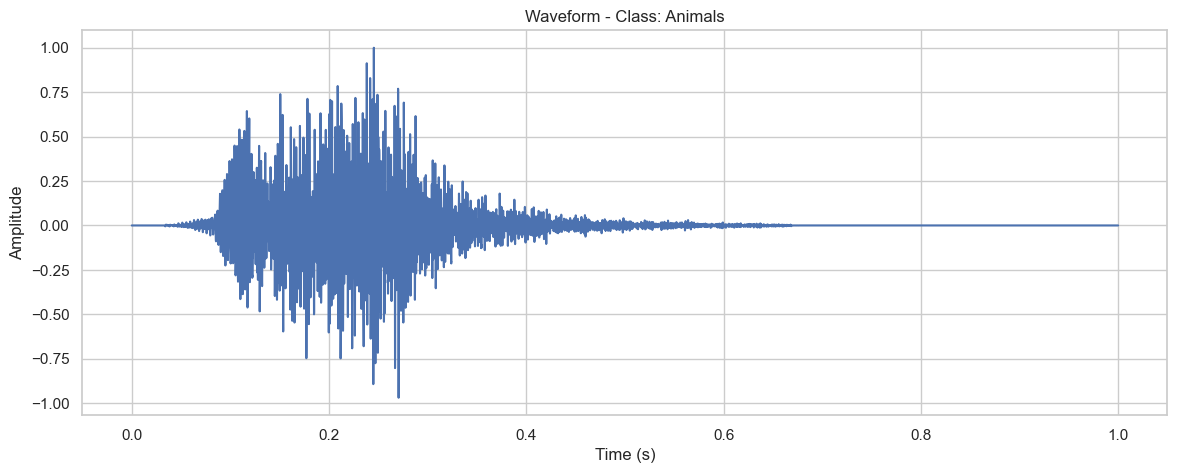

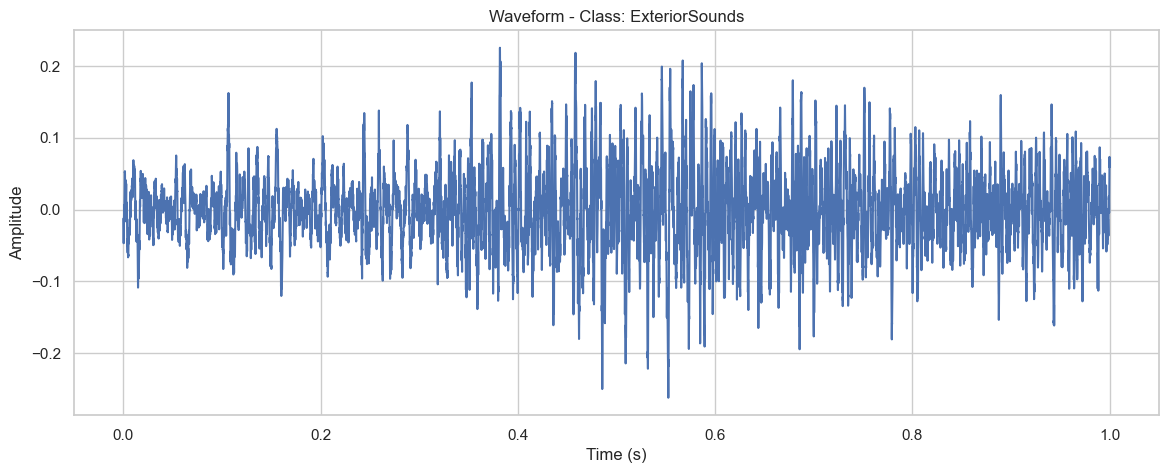

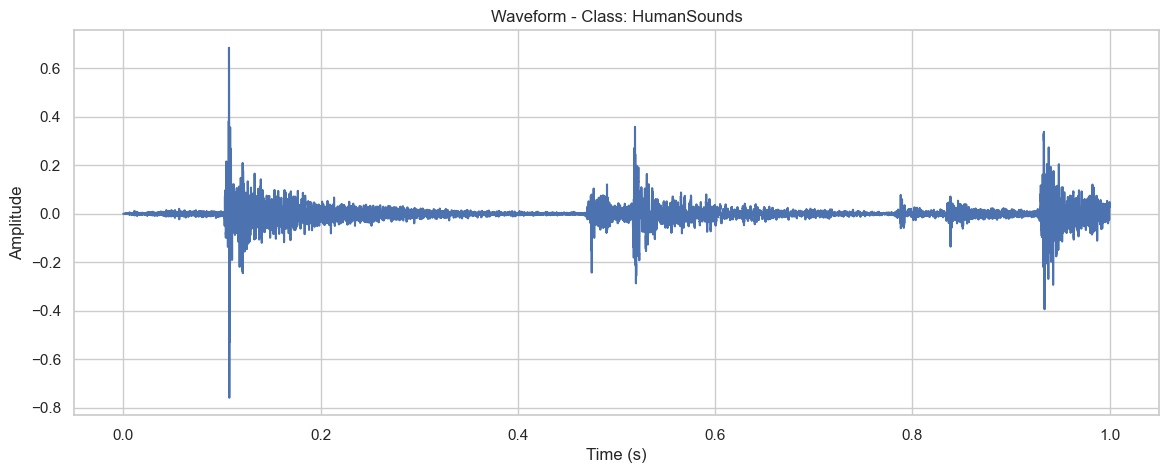

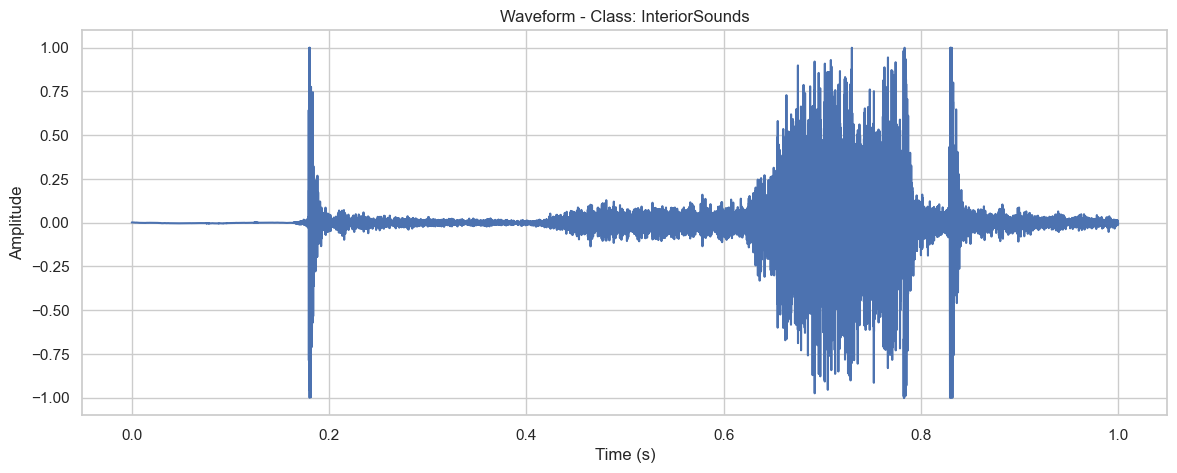

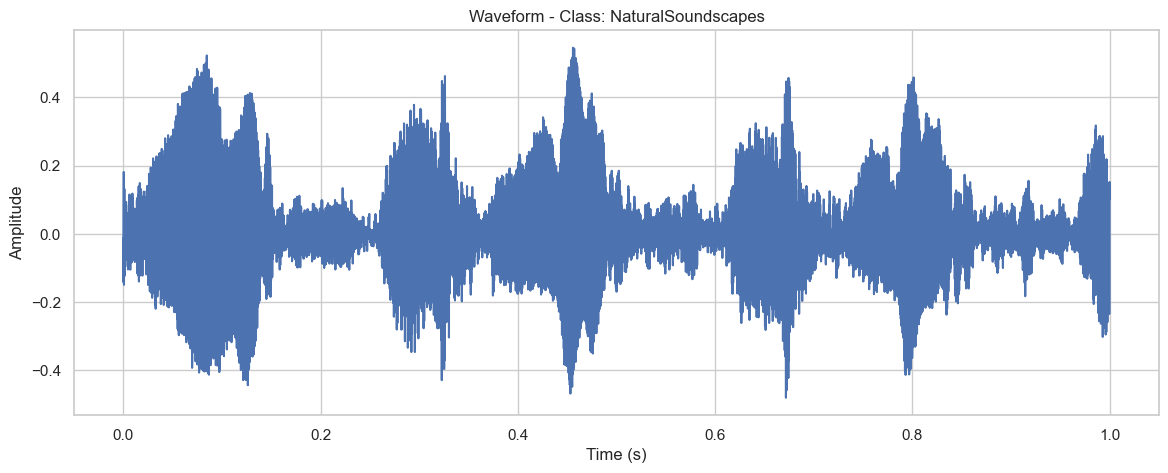

Feature shape: (5, 1025, 44)
Label shape: (5,)


In [34]:


# Path to the folder containing audio files
folder_path = "C:/College/DPL+EDA+PDS/Audio1"

# Function to extract features from audio file and perform length equalization
def extract_features(audio_file, target_length=22050):
    # Load audio file
    y, sr = librosa.load(audio_file, sr=None)

    # Trim silence from the audio
    y, _ = librosa.effects.trim(y)

    # Equalize length using zero-padding or truncation
    if len(y) < target_length:
        y = np.pad(y, (0, target_length - len(y)))
    else:
        y = y[:target_length]

    # Compute the spectrogram
    spectrogram = np.abs(librosa.stft(y))

    # Normalize the spectrogram
    spectrogram = normalize_spectrogram(spectrogram)

    return y, spectrogram

# Function to normalize the spectrogram
def normalize_spectrogram(spectrogram):
    # Perform peak normalization
    max_value = np.max(spectrogram)
    if max_value > 0:
        spectrogram /= max_value
    return spectrogram

# Lists to store features and labels
X = []  # Features
y = []  # Labels

# Loop through each class folder
for class_folder in os.listdir(folder_path):
    class_path = os.path.join(folder_path, class_folder)

    # Select only one audio file from each class
    audio_files = os.listdir(class_path)
    if audio_files:
        audio_file = os.path.join(class_path, audio_files[0])

        # Extract features and perform length equalization
        waveform, features = extract_features(audio_file)

        # Append features and corresponding label
        X.append(features)
        y.append(class_folder)

        # Visualize the waveform (optional)
        plt.figure(figsize=(14, 5))
        plt.plot(np.arange(len(waveform)) / sr, waveform)  # x-axis: time, y-axis: amplitude
        plt.title(f'Waveform - Class: {class_folder}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.show()

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# Print the shape of the feature and label arrays
print("Feature shape:", X.shape)
print("Label shape:", y.shape)


# DPL- Data Preprocessing Lab

## 1. Feature Extraction( MFCCs )

In [17]:

# Path to the folder containing audio files
folder_path = "C:/College/DPL+EDA+PDS/Audio1"

# Function to extract features from audio file
def extract_features(audio_file):
    # Load audio file
    y, sr = librosa.load(audio_file, sr=None)

    # Trim silence from the audio
    y, _ = librosa.effects.trim(y)

    # Extract MFCCs (Mel-frequency cepstral coefficients)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Aggregate the MFCCs to a single vector (e.g., taking the mean)
    mfccs_mean = np.mean(mfccs, axis=1)

    return mfccs_mean

# Lists to store features and labels
X = []  # Features
y = []  # Labels

# Loop through each class folder
for class_folder in os.listdir(folder_path):
    class_path = os.path.join(folder_path, class_folder)

    # Select only one audio file from each class
    audio_files = os.listdir(class_path)
    if audio_files:
        audio_file = os.path.join(class_path, audio_files[0])

        # Extract features
        features = extract_features(audio_file)

        # Append features and corresponding label
        X.append(features)
        y.append(class_folder)

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# Print the shape of the feature and label arrays
print("Feature shape:", X.shape)
print("Label shape:", y.shape)


Feature shape: (5, 13)
Label shape: (5,)


## 2. Feature Extraction( Spectograms )

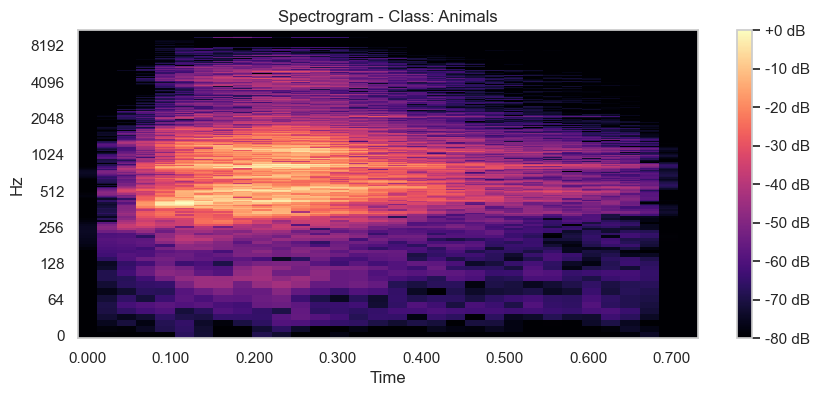

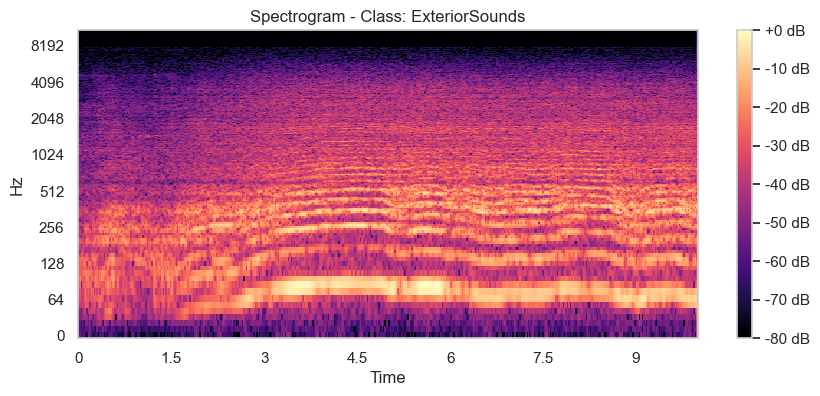

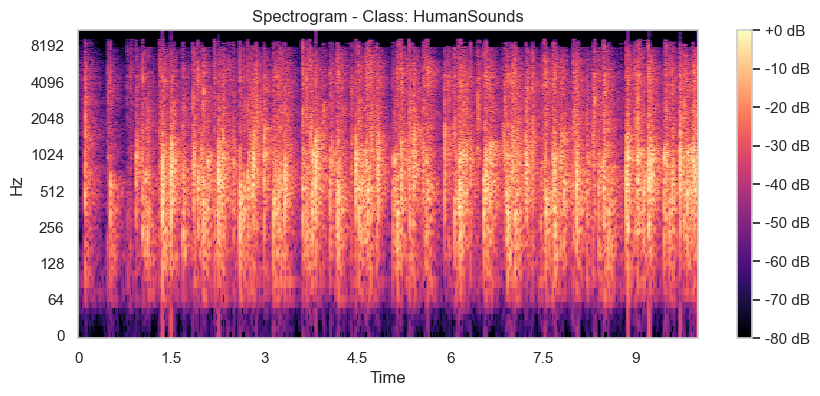

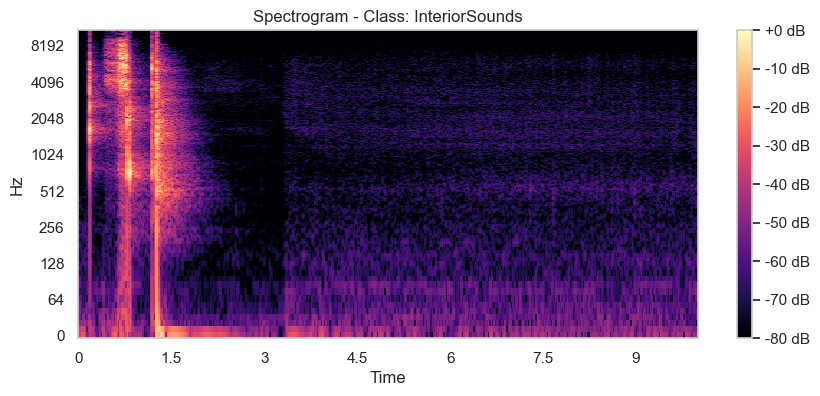

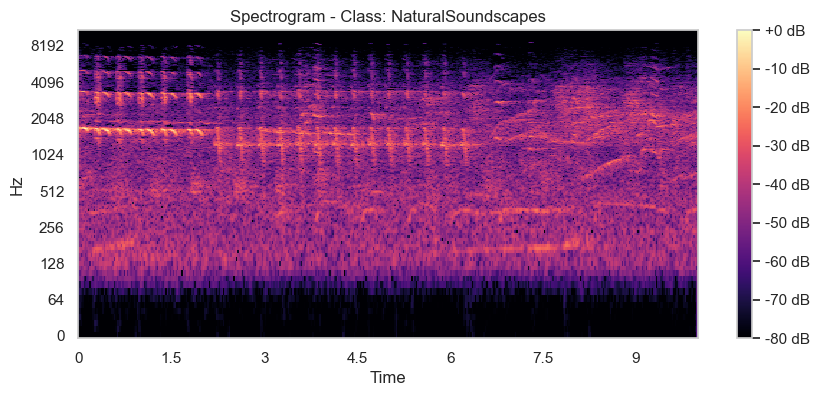

In [24]:


# Path to the folder containing audio files
folder_path = "C:/College/DPL+EDA+PDS/Audio1"

# Function to extract features from audio file
def extract_features(audio_file):
    # Load audio file
    y, sr = librosa.load(audio_file, sr=None)

    # Trim silence from the audio
    y, _ = librosa.effects.trim(y)

    # Compute the spectrogram
    spectrogram = np.abs(librosa.stft(y))

    return spectrogram

# Lists to store features and labels
X = []  # Features
y = []  # Labels

# Loop through each class folder
for class_folder in os.listdir(folder_path):
    class_path = os.path.join(folder_path, class_folder)

    # Select only one audio file from each class
    audio_files = os.listdir(class_path)
    if audio_files:
        audio_file = os.path.join(class_path, audio_files[0])

        # Extract features
        features = extract_features(audio_file)

        # Append features and corresponding label
        X.append(features)
        y.append(class_folder)

        # Visualize the spectrogram (optional)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(librosa.amplitude_to_db(features, ref=np.max), y_axis='log', x_axis='time')
        plt.title(f'Spectrogram - Class: {class_folder}')
        plt.colorbar(format='%+2.0f dB')
        plt.show()

# Convert lists to NumPy arrays



## 3. Equalization of the lengths of audio file

In [36]:


# Path to the folder containing audio files
folder_path = "C:/College/DPL+EDA+PDS/Audio1"

# Function to extract features from audio file and perform length equalization
def extract_features(audio_file, target_length=22050):
    # Load audio file
    y, sr = librosa.load(audio_file, sr=None)

    # Trim silence from the audio
    y, _ = librosa.effects.trim(y)

    # Equalize length using zero-padding or truncation
    if len(y) < target_length:
        y = np.pad(y, (0, target_length - len(y)))
    else:
        y = y[:target_length]

    # Compute the spectrogram
    spectrogram = np.abs(librosa.stft(y))

    # Normalize the spectrogram
    spectrogram = normalize_spectrogram(spectrogram)

    return y, spectrogram

# Function to normalize the spectrogram
def normalize_spectrogram(spectrogram):
    # Perform peak normalization
    max_value = np.max(spectrogram)
    if max_value > 0:
        spectrogram /= max_value
    return spectrogram

# Lists to store features and labels
X = []  # Features
y = []  # Labels

# Loop through each class folder
for class_folder in os.listdir(folder_path):
    class_path = os.path.join(folder_path, class_folder)

    # Select only one audio file from each class
    audio_files = os.listdir(class_path)
    if audio_files:
        audio_file = os.path.join(class_path, audio_files[0])

        # Extract features and perform length equalization
        waveform, features = extract_features(audio_file)

        # Append features and corresponding label
        X.append(features)
        y.append(class_folder)

       

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# Print the shape of the feature and label arrays
print("Feature shape:", X.shape)
print("Label shape:", y.shape)


Feature shape: (5, 1025, 44)
Label shape: (5,)


## 4. Making the dataset a csv file for ease of mapping

In [8]:
import os
import pandas as pd

# Set the path to your dataset directory
dataset_path = "C:/College/DPL+EDA+PDS/Audio1"

# Initialize empty lists to store file paths and corresponding labels
file_paths = []
labels = []

# Iterate through each class folder
for class_label in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_label)
    
    # Check if it's a directory
    if os.path.isdir(class_path):
        # Iterate through audio files in the class folder
        for audio_file in os.listdir(class_path):
            # Check if it's an audio file (you may need to customize this check based on your file format)
            if audio_file.endswith('.wav'):
                # Append file path and label to the lists
                file_paths.append(os.path.join(class_path, audio_file))
                labels.append(class_label)

# Create a DataFrame
df = pd.DataFrame({'file_path': file_paths, 'label': labels})

# Save DataFrame to CSV
df.to_csv('audio_dataset.csv', index=False)
df.head()


file_path    label
0  C:/College/DPL+EDA+PDS/Audio1\Animals\1-100032...  Animals
1  C:/College/DPL+EDA+PDS/Audio1\Animals\1-103298...  Animals
2  C:/College/DPL+EDA+PDS/Audio1\Animals\1-110389...  Animals
3  C:/College/DPL+EDA+PDS/Audio1\Animals\1-16568-...  Animals
4  C:/College/DPL+EDA+PDS/Audio1\Animals\1-202111...  Animals

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  600 non-null    object
 1   label      600 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB
